In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ghibtools as gh
import pandas as pd
import seaborn as sns
from params import *
from bibliotheque import get_pos, df_baseline, get_df_mask_chan_signif
from compute_bandpower import bandpower_job
from configuration import base_folder
import os

In [3]:
mask_params = dict(markersize=15, markerfacecolor='y')

In [4]:
pos = get_pos()

In [5]:
metrics = ['power_mean','power_median','power_integral']
indexes = ['band','session','chan','participant']

In [6]:
concat = []
for run_key in run_keys:
    concat.append(bandpower_job.get(run_key).to_dataframe())
bandpower = pd.concat(concat)

In [7]:
bandpower_baselined = df_baseline(bandpower, indexes, metrics)

<AxesSubplot: >

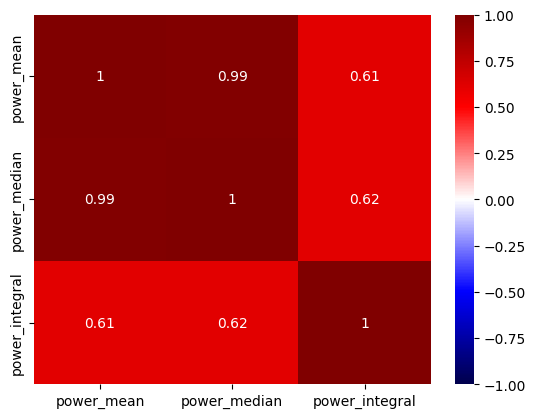

In [8]:
sns.heatmap(bandpower.corr(numeric_only = True), annot =True, vmin = -1, vmax = 1, cmap = 'seismic')

<AxesSubplot: >

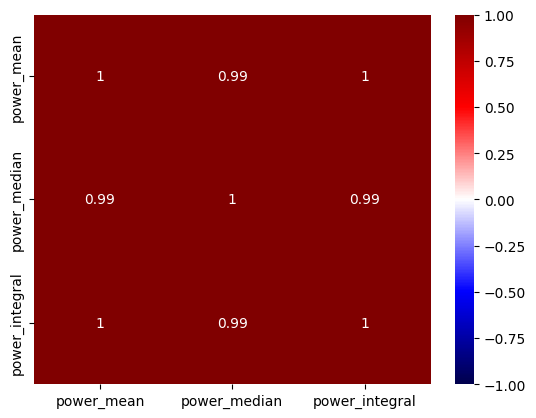

In [9]:
sns.heatmap(bandpower_baselined.corr(numeric_only = True), annot =True, vmin = -1, vmax = 1, cmap = 'seismic')

<AxesSubplot: xlabel='band', ylabel='power_integral'>

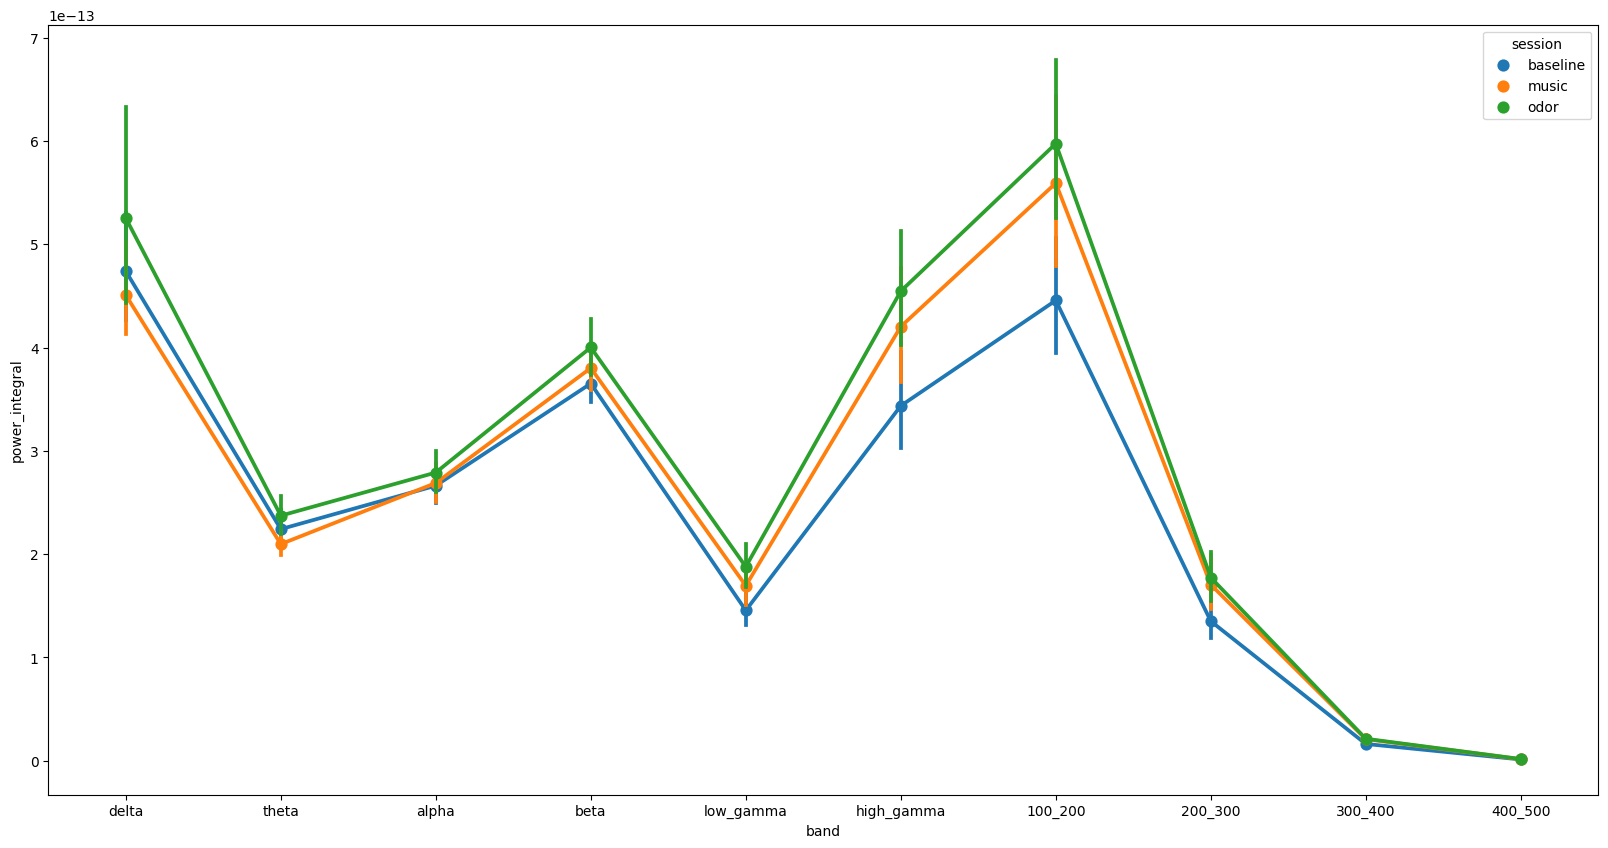

In [10]:
fig, ax = plt.subplots(figsize = (20,10))
sns.pointplot(data=bandpower, x = 'band', y = 'power_integral', hue = 'session',ax=ax)

<AxesSubplot: xlabel='band', ylabel='power_integral'>

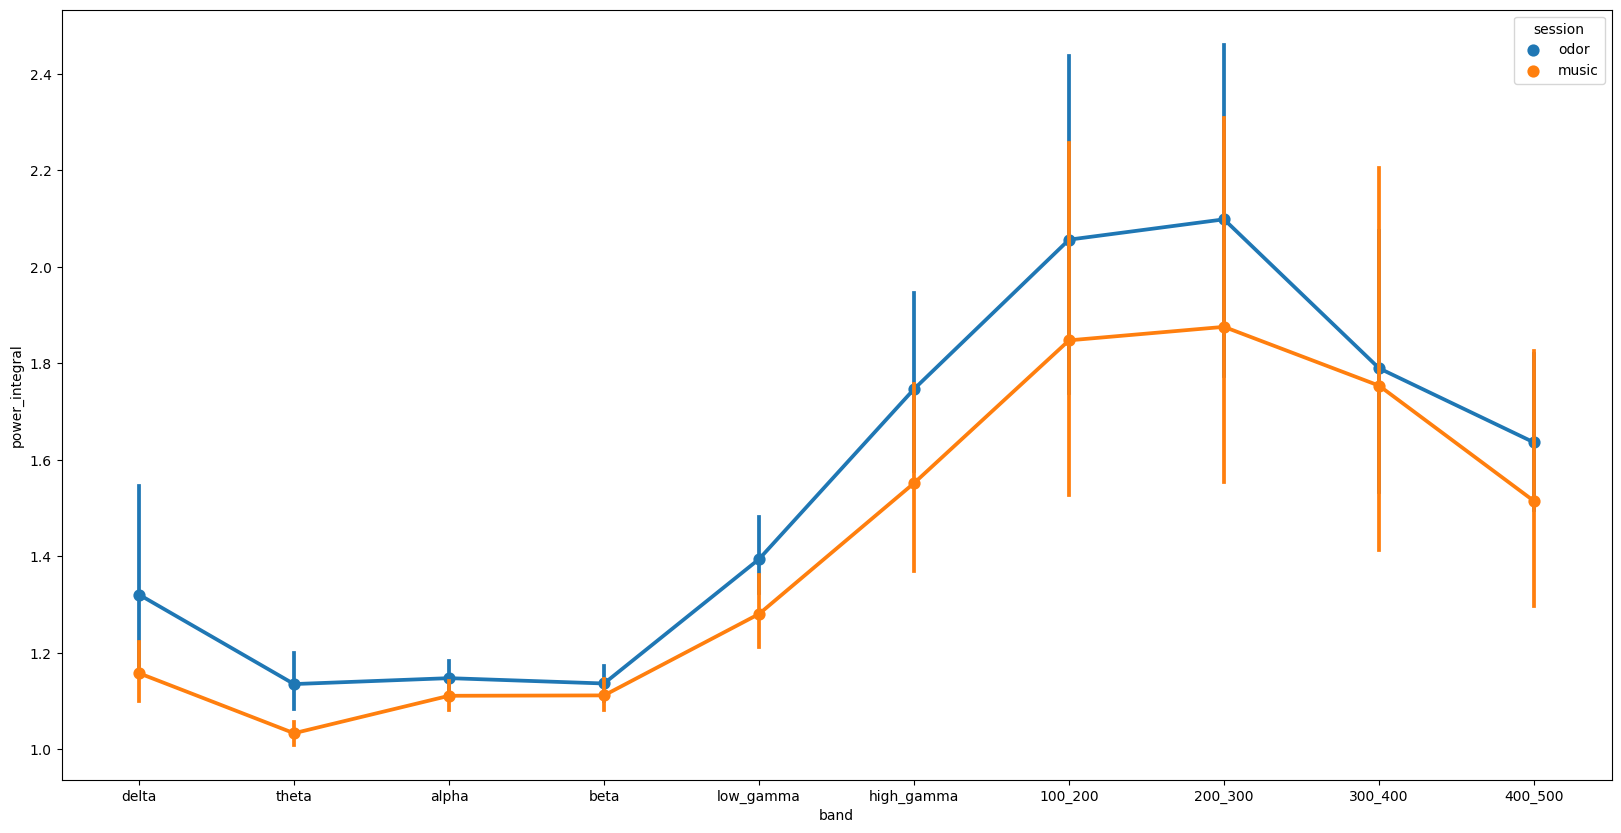

In [11]:
fig, ax = plt.subplots(figsize = (20,10))
sns.pointplot(data=bandpower_baselined, x = 'band', y = 'power_integral', hue = 'session',ax=ax)

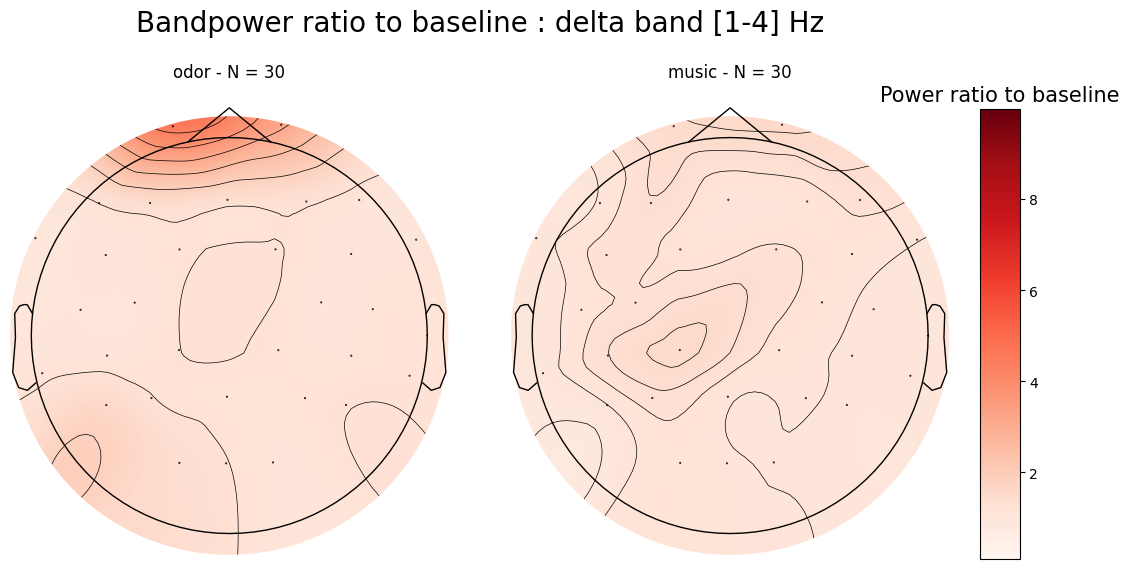

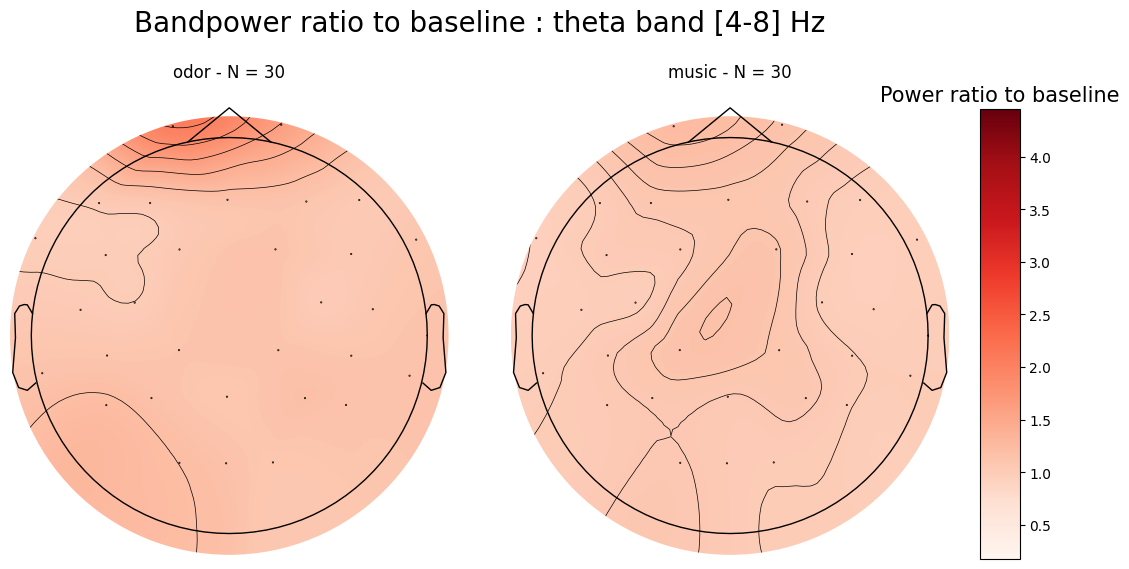

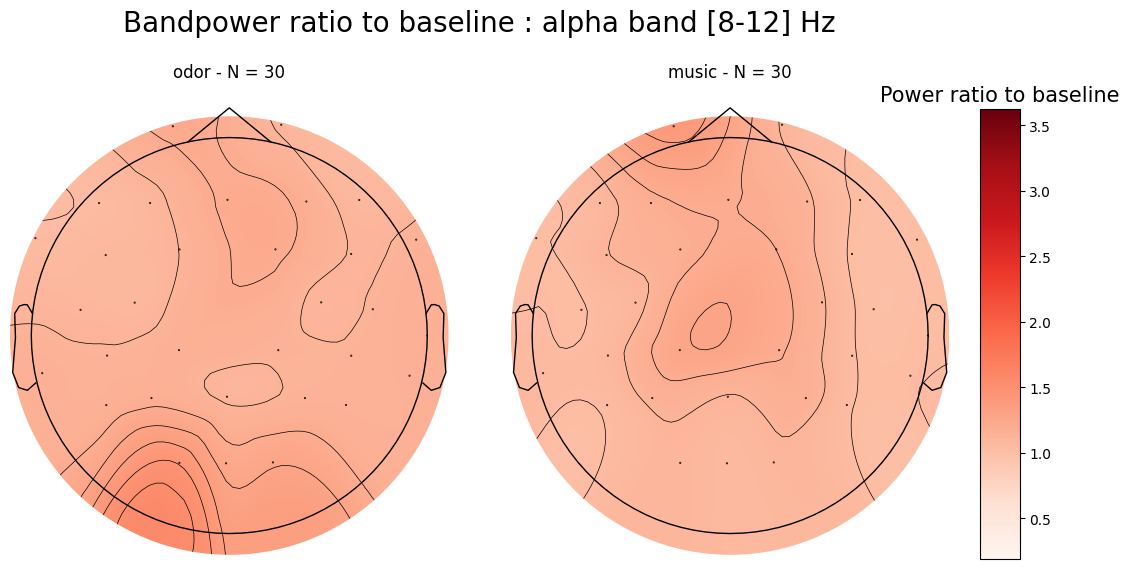

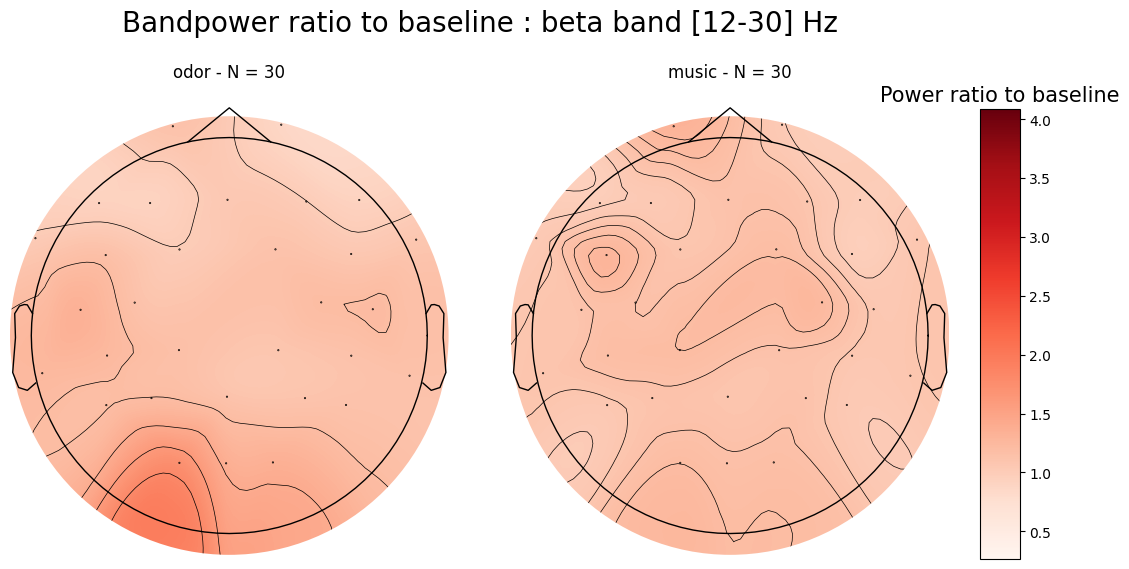

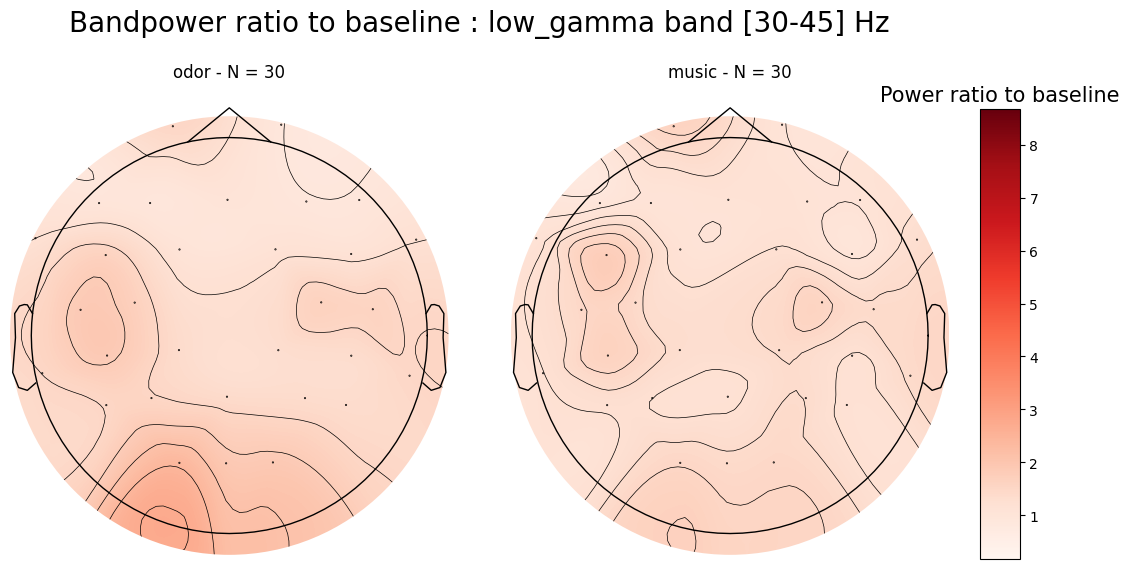

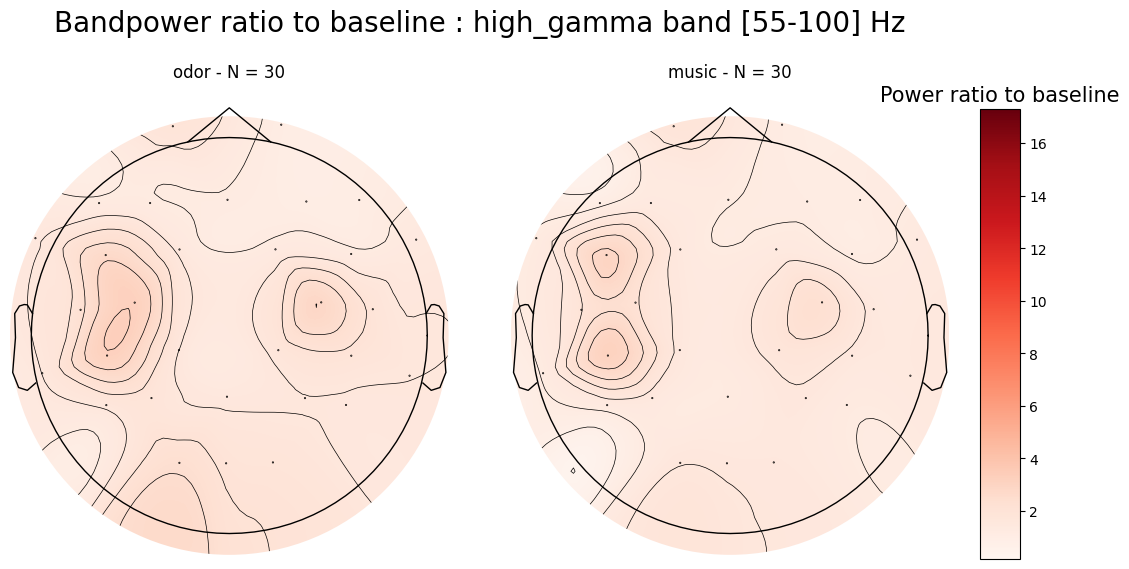

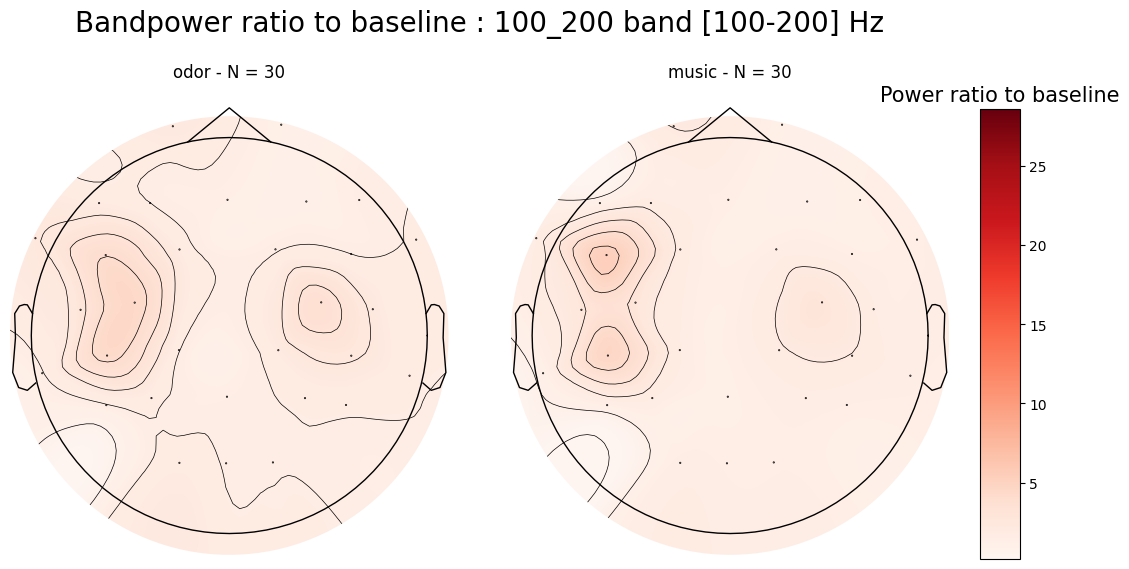

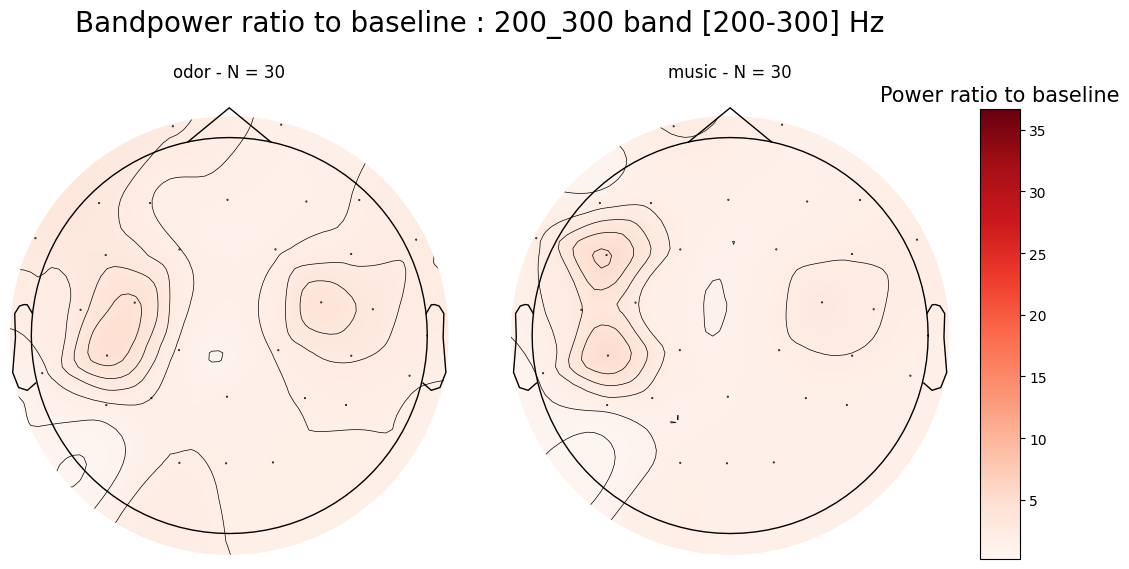

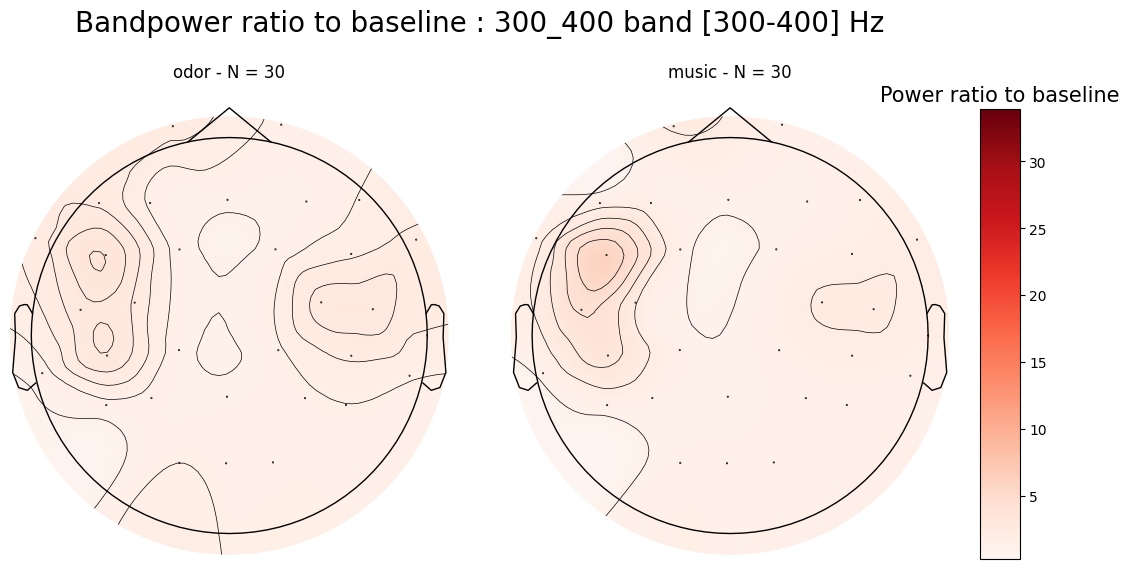

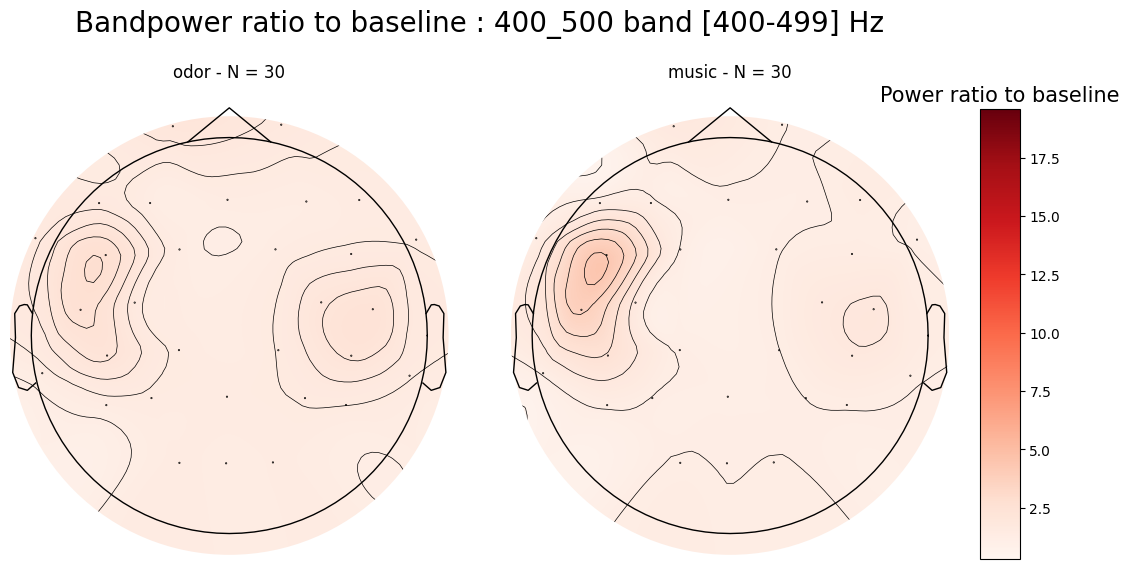

In [13]:
N = len(subject_keys)

for band in fbands.keys():
    bandpower_of_band = bandpower_baselined[bandpower_baselined['band'] == band]
    
    df_mask = get_df_mask_chan_signif(df = bandpower_of_band, chans = eeg_chans, predictor = 'session', outcome = 'power_integral', subject = 'participant')
    
    lc = fbands[band][0]
    hc = fbands[band][1]
    
    delta = 0.005
    mini = bandpower_of_band['power_integral'].quantile(delta)
    maxi = bandpower_of_band['power_integral'].quantile(1 - delta)
    
    vlim = (mini,maxi)

    fig, axs = plt.subplots(ncols = bandpower_of_band['session'].unique().size,figsize = (10,5), constrained_layout = True)
    fig.suptitle(f'Bandpower ratio to baseline : {band} band [{lc}-{hc}] Hz', fontsize = 20, y = 1.1)
    for c, session in enumerate(bandpower_of_band['session'].unique()):
        ax = axs[c]
        mask = bandpower_of_band[bandpower_of_band['session'] == session]
        data_ready = mask.groupby('chan').mean(numeric_only = True)['power_integral'].reindex(eeg_chans)
        data = data_ready.values
        im, _ = mne.viz.plot_topomap(data=data,pos = pos, names = eeg_chans, axes=ax, show = False, vlim=vlim, cmap = 'Reds', mask = df_mask['mask_corr'], mask_params = mask_params)
        
        ax.set_title(f'{session} - N = {N}')
        
    ax_x_start = 1
    ax_x_width = 0.04
    ax_y_start = 0
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('Power ratio to baseline',fontsize=15)
    
    file = base_folder / 'Figures' / 'bandpower' / 'global' / f'{band}.png'
    

    fig.savefig(file, bbox_inches = 'tight')


In [ ]:
N = len(subject_keys)

for subject in subject_keys:
    bandpower_subject = bandpower_baselined[bandpower_baselined['participant'] == subject]
    for band in fbands.keys():
        bandpower_of_band = bandpower_subject[bandpower_subject['band'] == band]

        lc = fbands[band][0]
        hc = fbands[band][1]

        delta = 0.005
        mini = bandpower_of_band['power_integral'].quantile(delta)
        maxi = bandpower_of_band['power_integral'].quantile(1 - delta)
        vlim = (mini,maxi)

        fig, axs = plt.subplots(ncols = bandpower_of_band['session'].unique().size,figsize = (10,5), constrained_layout = True)
        fig.suptitle(f'{subject} - Bandpower ratio to baseline : {band} band [{lc}-{hc}] Hz', fontsize = 20, y = 1.1)
        for c, session in enumerate(bandpower_of_band['session'].unique()):
            ax = axs[c]
            mask = bandpower_of_band[bandpower_of_band['session'] == session]
            data_ready = mask.groupby('chan').mean(numeric_only = True)['power_integral'].reindex(eeg_chans)
            data = data_ready.values
            im, _ = mne.viz.plot_topomap(data=data,pos = pos, names = eeg_chans, axes=ax, show = False, vlim=vlim, cmap = 'Reds')

            ax.set_title(f'{session}')

        ax_x_start = 1
        ax_x_width = 0.04
        ax_y_start = 0
        ax_y_height = 0.9
        cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
        clb = fig.colorbar(im, cax=cbar_ax)
        clb.ax.set_title('Power ratio to baseline',fontsize=15)
        
        save_folder = base_folder / 'Figures' / 'bandpower' / 'by_subject' / f'{band}'
        if not os.path.isdir(save_folder):
            os.mkdir(save_folder)
            
        file = save_folder / f'{subject}.png'
        fig.savefig(file, bbox_inches = 'tight')
        plt.close()